In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import glob
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import imgaug.augmenters as iaa
from imgaug import parameters as iap

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/IQ-OTH_NCCD lung cancer dataset.txt
/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (246).jpg
/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (155).jpg
/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (311).jpg
/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (45).jpg
/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (298).jpg
/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (359).jpg
/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (230).jpg
/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-O

# Data Setting

In [3]:
data_dir = "/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset"
label_dirs = ['Bengin cases', 'Malignant cases', 'Normal cases']
out_dir = '/kaggle/working'

In [6]:
# Create the Hyperparameters
BATCH_SIZE = 62
IMAGE_SIZE = 224
EPOCHS=100
CHANNELS=3

In [7]:
# Read the dataset using directory
directory = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1097 files belonging to 3 classes.


In [ ]:
#train_ratio = 0.7
#val_ratio = 0.15
#test_ratio = 0.15

In [9]:
# get class names associated with dataset images
categories = directory.class_names
print(repr(categories))

['Bengin cases', 'Malignant cases', 'Normal cases']


In [12]:
import cv2
# initialze an empty dictionary to carry the size of each image
size_data = {}
for i in categories:
    path = os.path.join('/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset', i)
    class_num = categories.index(i)
    temp_dict = {}

    # iterate over the images in the dataset
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath)
        Original_image_Size = np.shape(img)
        if len(Original_image_Size) > 2:

          # get height, width and channels for each image
            height, width, channels = cv2.imread(filepath).shape
            if str(height) + ' x ' + str(width) in temp_dict:
                temp_dict[str(height) + ' x ' + str(width)] += 1
            else:
                temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

In [14]:
# get the number of images for each image size in the dataset
for key in size_data:
  print(key, '->', size_data[key])

Bengin cases -> {'512 x 512': 120}
Malignant cases -> {'512 x 512': 501, '512 x 623': 31, '512 x 801': 28, '404 x 511': 1}
Normal cases -> {'512 x 512': 415, '331 x 506': 1}


In [15]:
# get the total number of images on each class
bengin_num = sum(size_data['Bengin cases'].values())
malignant_num = sum(size_data['Malignant cases'].values())
normal_num = sum(size_data['Normal cases'].values())

print("Number of Benign Cases ->", bengin_num)
print("Number of Malignant Cases ->", malignant_num)
print("Number of Normal Cases ->", normal_num)

Number of Benign Cases -> 120
Number of Malignant Cases -> 561
Number of Normal Cases -> 416


In [16]:
# list the number of images on each class to be passed later to the charts
num_list = [bengin_num, malignant_num, normal_num]
print(num_list)

[120, 561, 416]


In [17]:
# get the total number of images
all_image = malignant_num + bengin_num + normal_num
print("Total Number of Images ->", all_image)

Total Number of Images -> 1097


In [18]:
# get the total number of images
all_image = malignant_num + bengin_num + normal_num
print("Total Number of Images ->", all_image)

Total Number of Images -> 1097


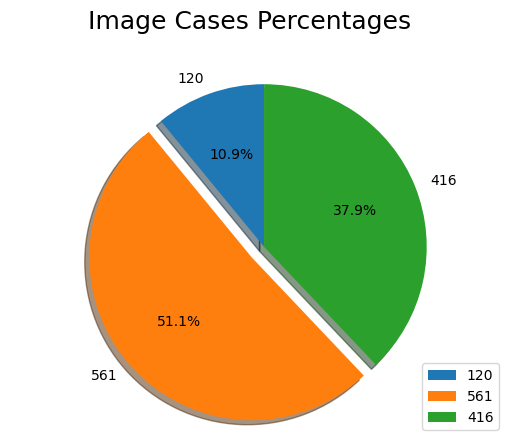

In [19]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(num_list, explode=explode, labels=num_list, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle('Image Cases Percentages', y=1, fontsize=18)
plt.legend(loc = 'lower right')

plt.show()

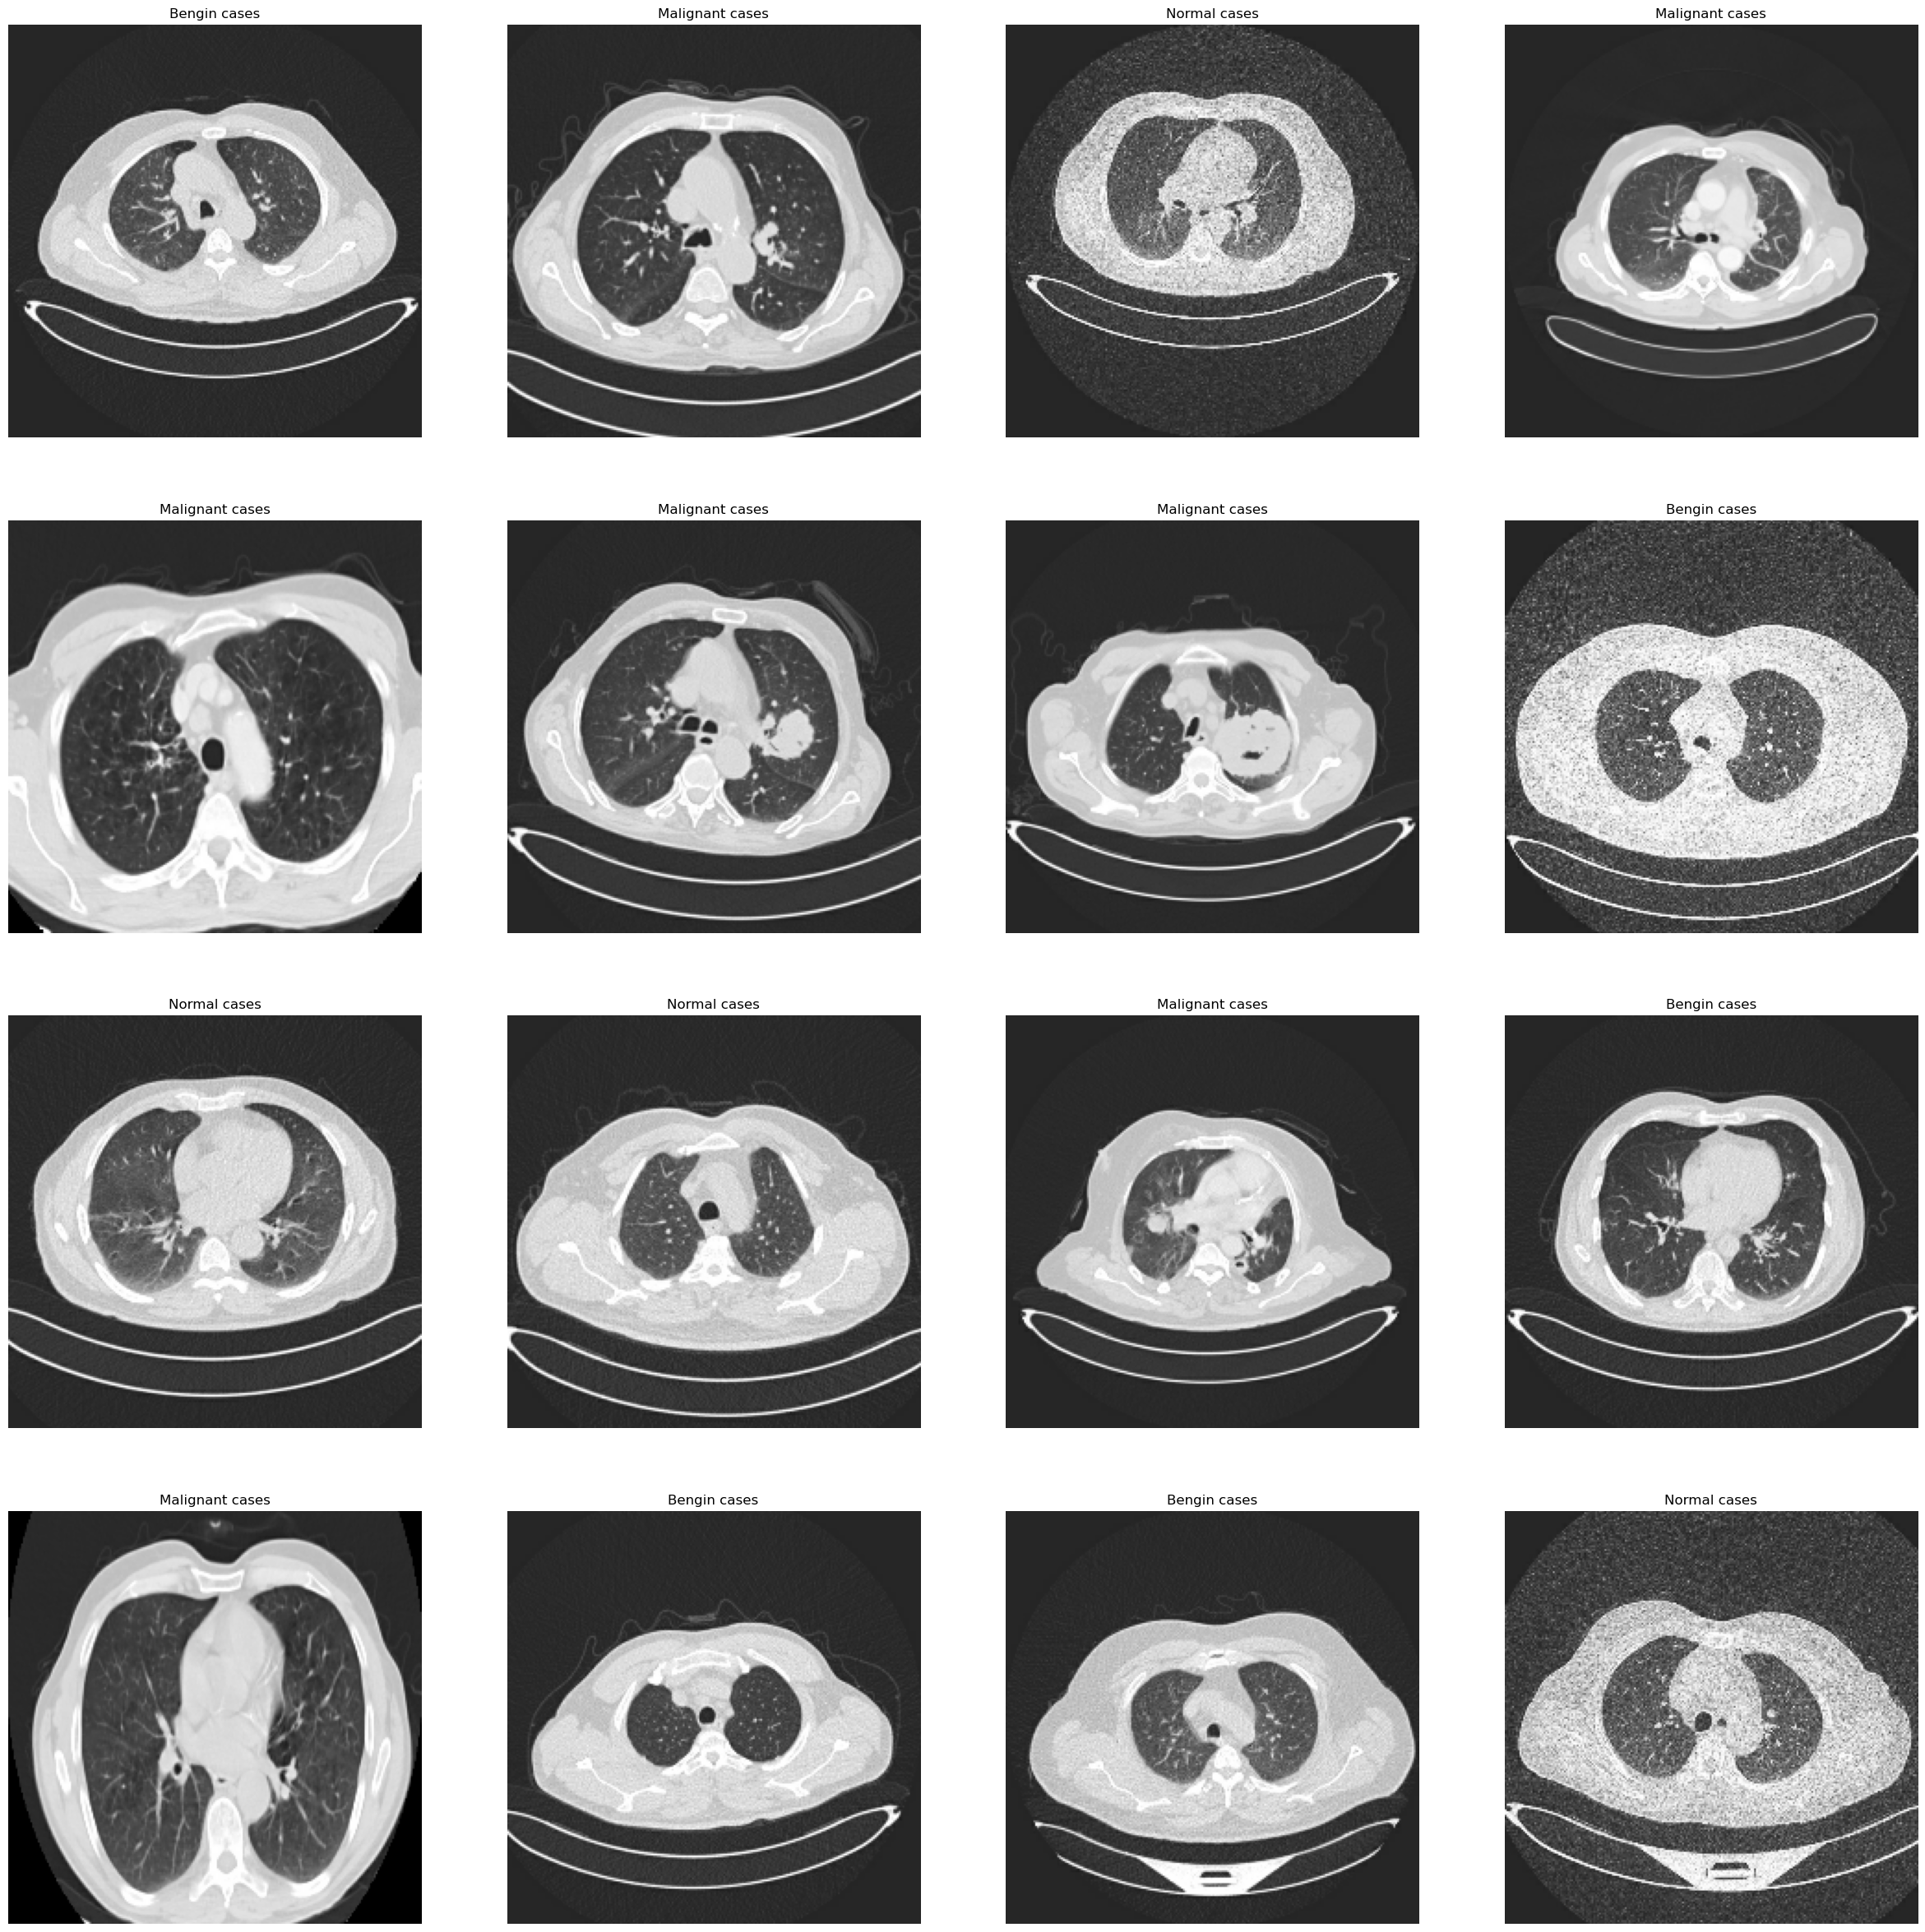

In [20]:
plt.figure(figsize = (30,30))

for images, labels in directory.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(categories[labels[i]])
    plt.axis('off')

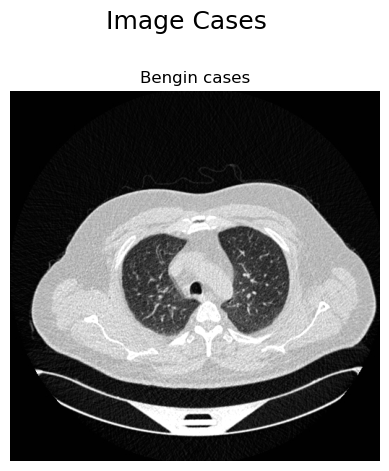

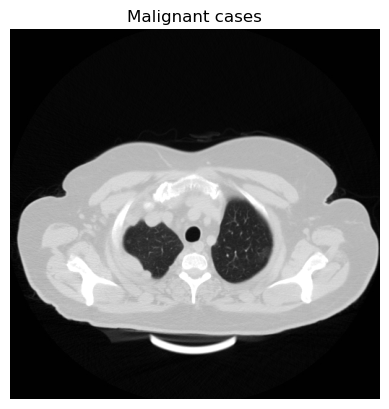

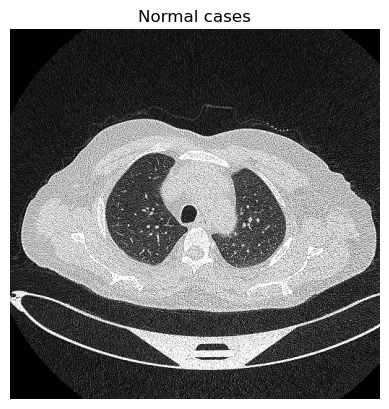

In [21]:
# show a sample from each class of images
plt.suptitle('Image Cases', y=1.05, fontsize=18)
for i in categories:
    path = os.path.join('/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset', i)
    class_num = categories.index(i)

    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        plt.imshow(img, cmap='gray')  # Display grayscale image
        plt.axis("off")
        plt.title(i)
        plt.show()
        break  # To show only one sample image per class

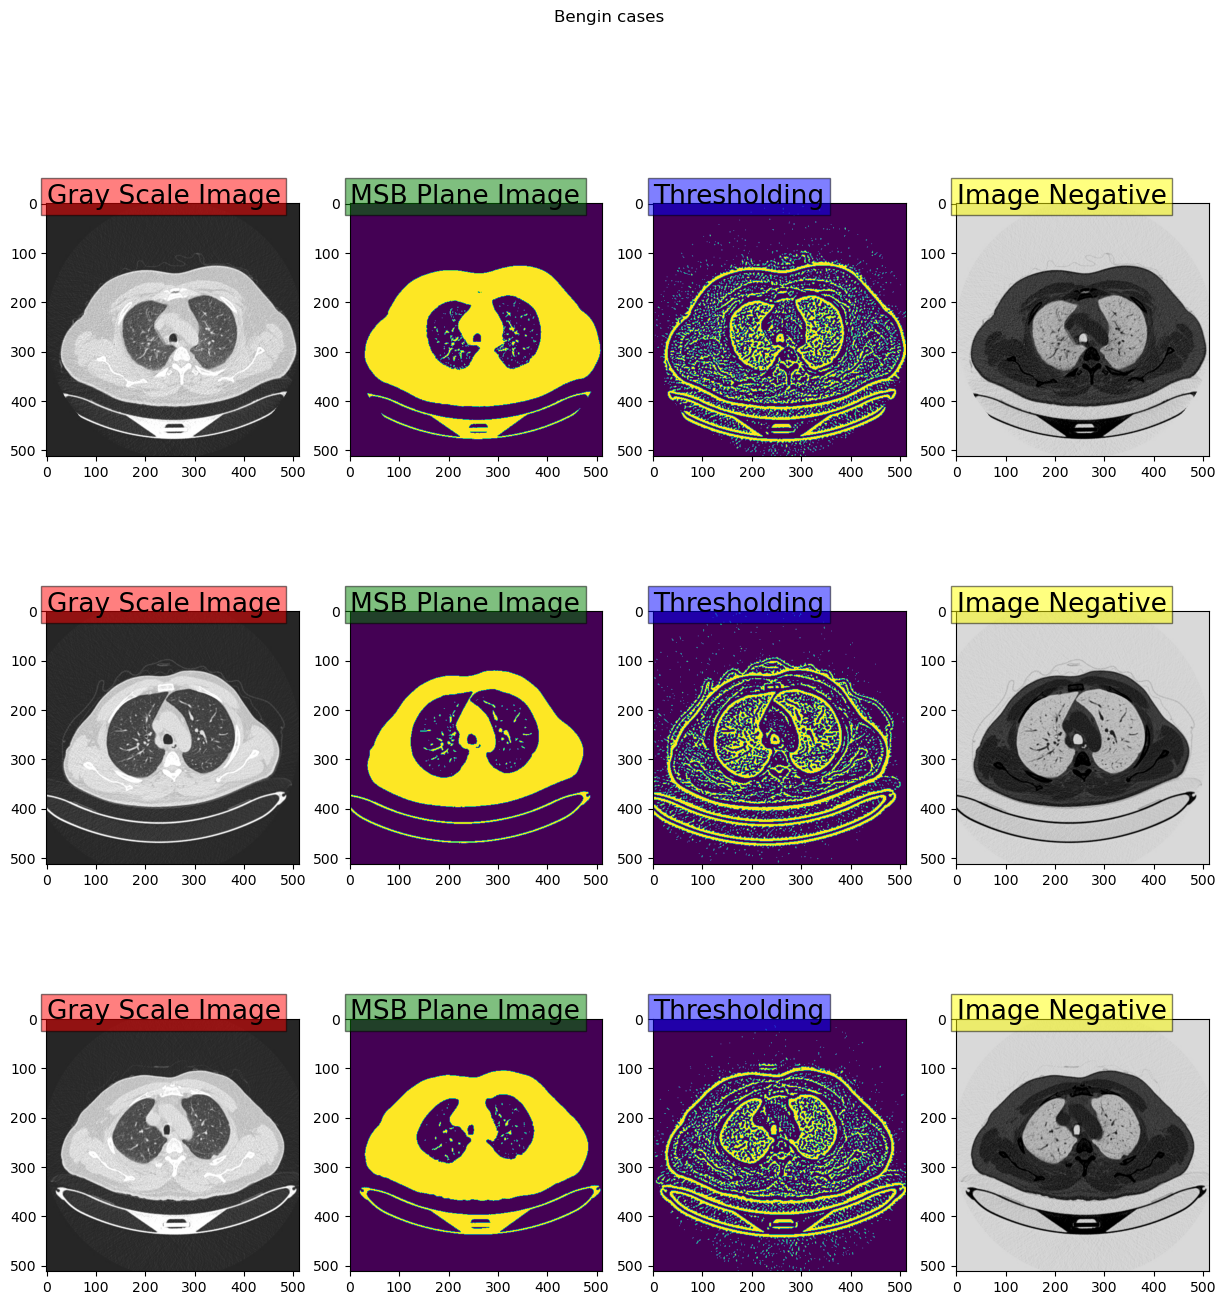

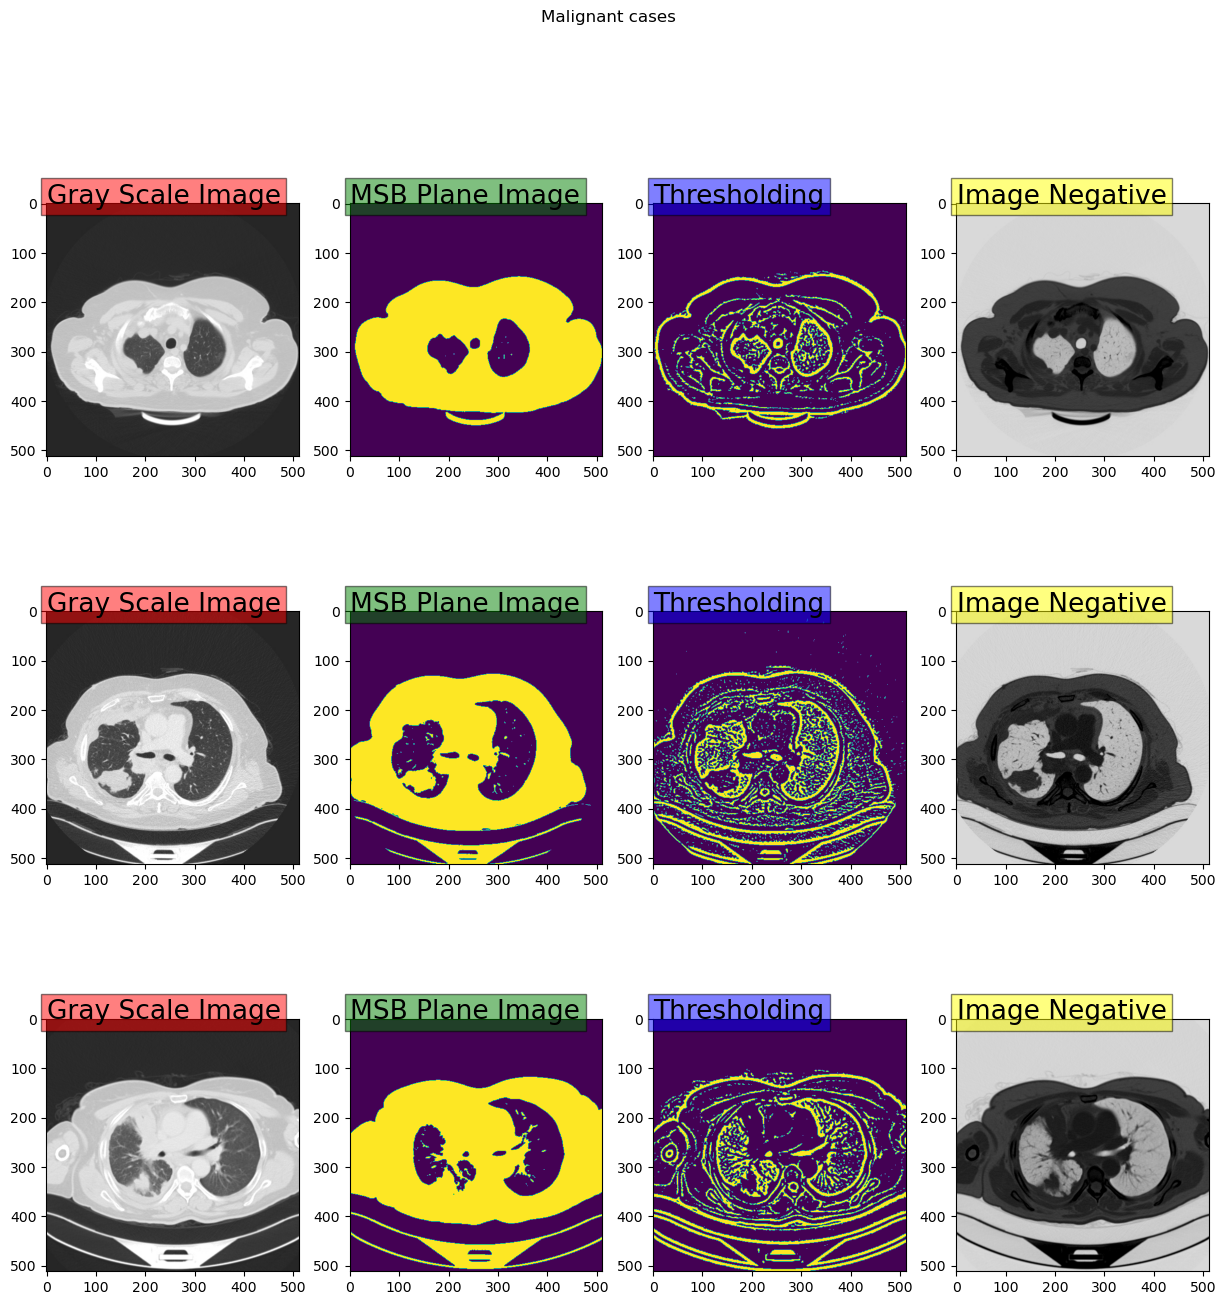

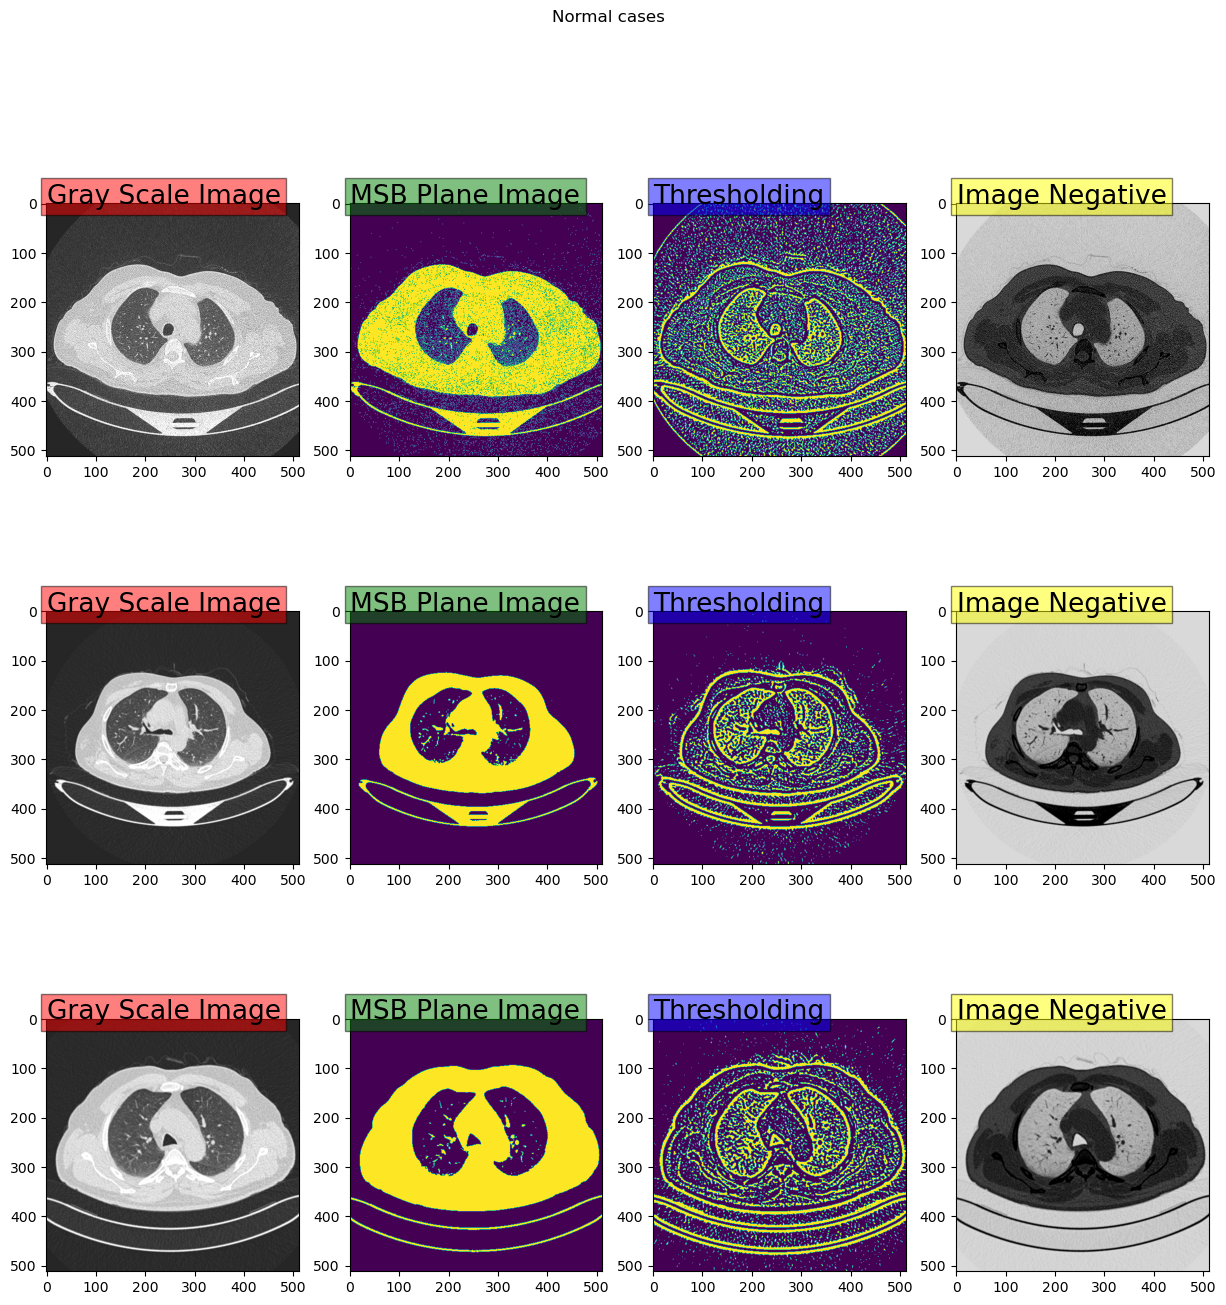

In [22]:
# Apply the filters on class of images
for i in categories:
    # take 3 samples from each class to be proccessed
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 4, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join('/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset', i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath)

        # Convert to grayscals
        gray = cv2.imread(filepath, 0)

        # Resizing images with the target image size
        img0 = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        # Apply GaussianBlur to smooth the image (remove any spark noise that maybe affect the sharpening filters)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply Adaptive thresholding to get the high components (details or edges) in the image
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11, 4)
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)


        # Apply Bit Plane Slicing to select the image with highest details and neglect other planes
        lst = []
        for i in range(gray.shape[0]):
            for j in range(gray.shape[1]):
                lst.append(np.binary_repr(gray[i][j] ,width=8)) # width = no. of bits

        eight_bit_img = (np.array([int(i[0]) for i in lst],dtype = np.uint8) * 128).reshape(gray.shape[0],gray.shape[1])


        # Apply Image Negative to reverse the image from white to black or vise versa
        arr = np.array(gray)
        invert = np.array(img)
        Max = np.max(invert)
        for i in range(invert.shape[0]):
            for j in range(invert.shape[1]):
                invert[i, j] = Max - invert[i, j]

        # give a title for each image after applying the filter

        ax[cnt, 0].text(0.5, 0.5, 'Gray Scale Image', fontsize=19, bbox=dict(facecolor='red', alpha=0.5))
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].text(0.5, 0.5, 'MSB Plane Image', fontsize=19, bbox=dict(facecolor='green', alpha=0.5))
        ax[cnt, 1].imshow(eight_bit_img)
        ax[cnt, 2].text(0.5, 0.5, 'Thresholding', fontsize=19, bbox=dict(facecolor='blue', alpha=0.5))
        ax[cnt, 2].imshow(thresh)
        ax[cnt, 3].text(0.5, 0.5, 'Image Negative', fontsize=19, bbox=dict(facecolor='yellow', alpha=0.5))
        ax[cnt, 3].imshow(invert)
        cnt += 1
        if cnt == samples:
            break
plt.show()

In [24]:
data_dir = '/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'
label_dirs = ['Bengin cases', 'Malignant cases', 'Normal cases']
out_dir = '/kaggle/working'

In [27]:
label_dirs

['Bengin cases', 'Malignant cases', 'Normal cases']

In [29]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [30]:
import shutil

for label in label_dirs:
    img_paths = glob.glob(os.path.join(data_dir, label, "*.jpg"))

    
    random_seed = 42  

    
    train_paths, rest_paths = train_test_split(img_paths, train_size=train_ratio, random_state=random_seed)
    val_paths, test_paths = train_test_split(rest_paths, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed)

   
    for phase, paths in zip(["train", "val", "test"], [train_paths, val_paths, test_paths]):
        phase_dir = os.path.join(out_dir, phase)
        if not os.path.exists(phase_dir):
            os.makedirs(phase_dir)

        label_dir = os.path.join(phase_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

        for path in paths:
            dst_path = os.path.join(label_dir, os.path.basename(path))
            shutil.copy(path, dst_path)  


In [31]:
train_bingin = '/kaggle/working/train/Bengin cases'
train_malignant = '/kaggle/working/train/Malignant cases'
train_normal = '/kaggle/working/train/Normal cases'

In [32]:
val_bingin = '/kaggle/working/val/Bengin cases'
val_malignant = '/kaggle/working/val/Malignant cases'
val_normal = '/kaggle/working/val/Normal cases'

**augmentation**

In [33]:
def create_augmentation_seq():
    augmentation_seq = iaa.Sequential([
      iaa.Rot90([1, 2, 3]),
      iaa.Fliplr(0.5),
      iaa.Affine(translate_px=iap.DiscreteUniform(-10, 10), scale=(0.9, 1.1)),
      iaa.CropAndPad(px=(-10, 10)),
      iaa.AdditiveGaussianNoise(scale=(0, 30)),
      iaa.LinearContrast((0.9, 1.1)),
    ])
    return augmentation_seq


In [34]:
def augment_and_save_images(input_path, output_path, num_augmented):
    img = Image.open(input_path)
    img_np = np.array(img)
    augmentation_seq = create_augmentation_seq()

    for i in range(num_augmented):
        aug_img_np = augmentation_seq(image=img_np)
        aug_img = Image.fromarray(aug_img_np)
        save_path = os.path.join(output_path, f"augmented_{i}_{os.path.basename(input_path)}")
        aug_img.save(save_path)

In [35]:
class_folders = [train_bingin, train_malignant, train_normal]

for class_folder in class_folders:
    image_paths = glob.glob(os.path.join(class_folder, "*.jpg"))

    for img_path in image_paths:
        augment_and_save_images(img_path, class_folder, num_augmented=4)

In [36]:
class_folders = [val_bingin, val_malignant, val_normal]

for class_folder in class_folders:
    image_paths = glob.glob(os.path.join(class_folder, "*.jpg"))

    for img_path in image_paths:
        augment_and_save_images(img_path, class_folder, num_augmented=4)

In [38]:
# train, val,test direction
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'
val_dir = '/kaggle/working/val'

In [43]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS=100
CHANNELS=3

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 batch_size = BATCH_SIZE,
                                                                 shuffle = True)
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                               batch_size = BATCH_SIZE,
                                                               shuffle = False) 

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                               batch_size = BATCH_SIZE,
                                                               shuffle = False) 

Found 3835 files belonging to 3 classes.
Found 820 files belonging to 3 classes.
Found 166 files belonging to 3 classes.


In [44]:
#  train data size
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [45]:
class_names = train_data.class_names
print(class_names)

['Bengin cases', 'Malignant cases', 'Normal cases']


**sample image visualization**

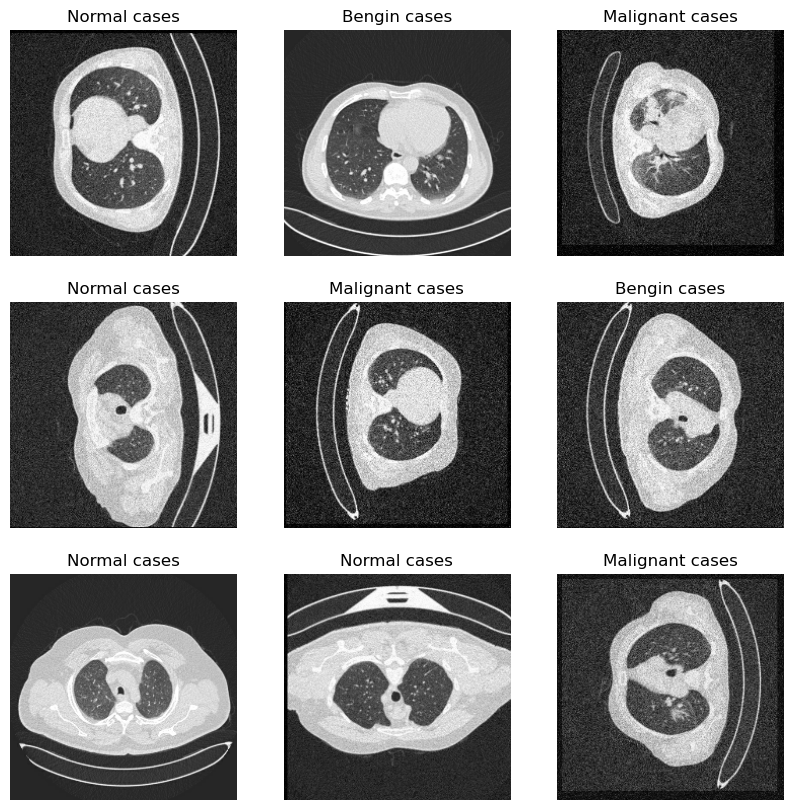

In [46]:
plt.figure(figsize = (10,10))

for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [47]:
image_batch

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[ 3.6989796 ,  3.6989796 ,  3.6989796 ],
         [ 0.        ,  0.        ,  0.        ],
         [ 2.1887748 ,  2.1887748 ,  2.1887748 ],
         ...,
         [ 1.5561457 ,  1.5561457 ,  1.5561457 ],
         [ 1.0969433 ,  1.0969433 ,  1.0969433 ],
         [ 3.0304477 ,  3.0304477 ,  3.0304477 ]],

        [[ 3.622449  ,  3.622449  ,  3.622449  ],
         [ 1.8622454 ,  1.8622454 ,  1.8622454 ],
         [ 3.4489815 ,  3.4489815 ,  3.4489815 ],
         ...,
         [34.913406  , 34.913406  , 34.913406  ],
         [ 6.9641895 ,  6.9641895 ,  6.9641895 ],
         [ 3.4285011 ,  3.4285011 ,  3.4285011 ]],

        [[ 3.5816326 ,  3.5816326 ,  3.5816326 ],
         [ 1.9132656 ,  1.9132656 ,  1.9132656 ],
         [ 1.7142868 ,  1.7142868 ,  1.7142868 ],
         ...,
         [40.714417  , 40.714417  , 40.714417  ],
         [ 7.8417296 ,  7.8417296 ,  7.8417296 ],
         [ 2.6428576 ,  2.6428576 ,  2.642857

In [50]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 255.0


**normalization**

In [51]:
def standard(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -1   # Between -1 to 1
    return image, label

In [52]:
train = train_data.map(standard)
validation = val_data.map(standard)

In [53]:
for normal_batch, train_label in train:
  print(normal_batch.shape)
  print(train_label.shape)
  break

(32, 224, 224, 3)
(32,)


In [54]:
train_label

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1,
       0, 1, 2, 1, 2, 2, 2, 1, 1, 1], dtype=int32)>

In [55]:
for val_batch, val_label in validation:
  print(normal_batch.shape)
  print(train_label.shape)
  break

(32, 224, 224, 3)
(32,)


In [56]:
# max, min 
# -1, +1
normal_image = normal_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(normal_image), np.max(normal_image))

-1.0 1.0


In [57]:
val_image = val_batch[0]
print(np.min(val_image), np.max(val_image))

-0.8231693 1.0


# CNN Modeling

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense

In [60]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = IMG_SHAPE),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2 ,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'), 
    Dense(3, activation='softmax') 
])

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [63]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
history = model.fit(train,
                    batch_size=32,
                    epochs=10,
                    validation_data=validation)

Epoch 1/10
120/120 [==============================] - 24s 112ms/step - loss: 1.2585 - accuracy: 0.6542 - val_loss: 0.7148 - val_accuracy: 0.7305
Epoch 2/10
120/120 [==============================] - 13s 104ms/step - loss: 0.6210 - accuracy: 0.7439 - val_loss: 0.6094 - val_accuracy: 0.7671
Epoch 3/10
120/120 [==============================] - 14s 107ms/step - loss: 0.4592 - accuracy: 0.8130 - val_loss: 0.5400 - val_accuracy: 0.7988
Epoch 4/10
120/120 [==============================] - 13s 101ms/step - loss: 0.3179 - accuracy: 0.8743 - val_loss: 0.6311 - val_accuracy: 0.7622
Epoch 5/10
120/120 [==============================] - 12s 99ms/step - loss: 0.2062 - accuracy: 0.9252 - val_loss: 0.6334 - val_accuracy: 0.8073
Epoch 6/10
120/120 [==============================] - 13s 104ms/step - loss: 0.1173 - accuracy: 0.9575 - val_loss: 0.7719 - val_accuracy: 0.7890
Epoch 7/10
120/120 [==============================] - 13s 100ms/step - loss: 0.0712 - accuracy: 0.9778 - val_loss: 0.8975 - val_acc

# Model Evaluate

In [65]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

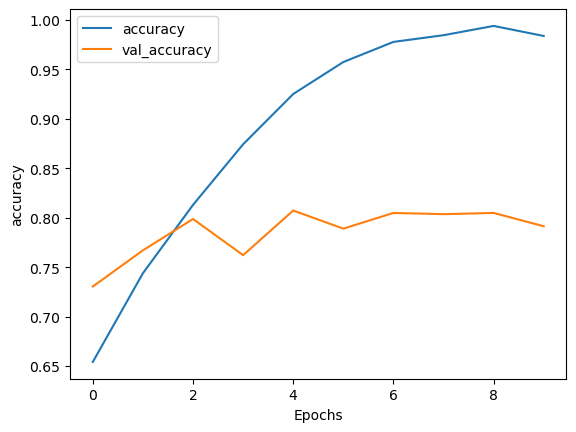

In [66]:
plot_graghs(history, 'accuracy')

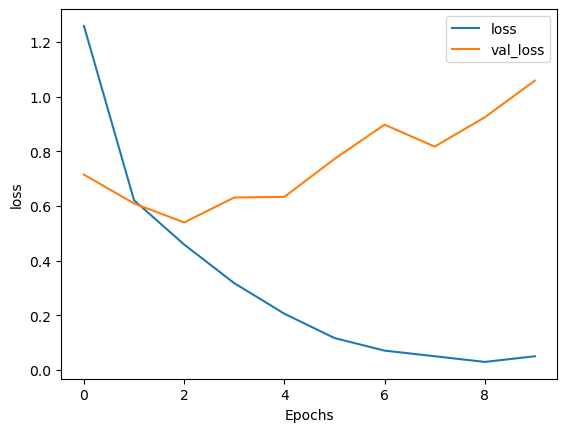

In [68]:
plot_graghs(history, 'loss')

In [70]:
test = test_data.map(standard)

In [71]:
result = model.evaluate(test)
print("Test loss, Test accuracy : ", result)

6/6 [==============================] - 1s 94ms/step - loss: 0.1745 - accuracy: 0.9759
Test loss, Test accuracy :  [0.1744927167892456, 0.9759036302566528]
